# Basic Preprocessing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
df = pd.read_csv("db_sfc_ta_dd.csv")
df

In [5]:
def preprocess(df, dfname = "", to_csv = False):
    if type(df) == str: #df대신 df 경로 및 파일명 입력시
        df = pd.read_csv(df, encoding = "utf-8-sig")
    if df.columns[0] == "Unnamed: 0":
        df = df.loc[:, 1:]
    df.columns = [x.replace("a.", "") for x in df.columns] #colnames
    df["yyyymmdd"] = df[df.columns[0]].apply(lambda x: int(x.split(" ")[0].replace("-", "")))
    df = df.loc[:, df.isnull().mean() != 1]
    if to_csv == True:
        df.to_csv(dfname + ".csv", index = False, encoding = "utf-8-sig")
    return df

def daily(df, back, dfname = "", to_csv = False):
    if type(df) == str: #df대신 df 경로 및 파일명 입력시
        df = pd.read_csv(df, encoding = "utf-8-sig")
    final = pd.DataFrame()
    for s in df["stn_id"].unique():
        print(s, " is processing")
        ss = pd.merge(back, df[df["stn_id"] == s], how = "left", on = "yyyymmdd")
        ss["stn_id"] = s
        final = pd.concat([final, ss], axis = 0)
    if to_csv == True:
        final.to_csv(dfname + ".csv", encoding = "utf-8-sig", index = False)
    return final

def after_daily(df, area, dfname = "", to_csv = False):
    if type(df) == str:
        df = pd.read_csv(df)
    if "isnull" in df.columns:
        df.drop("isnull", axis = 1, inplace = True)
    df.drop(df.columns[["Unnamed" in x for x in df.columns]], axis = 1, inplace = True)
    tm = df.columns[["tm" in x for x in df.columns]][0]
    df[tm] = df["yyyymmdd"].apply(lambda x: str(x)[:4] + "-" + str(x)[4:6] + "-" + str(x)[6:])
    idx = df.columns[[x not in ["yyyymmdd", tm, "stn_id"] for x in df.columns]]
    print(idx)
    df = pd.merge(df, area, how = "left", on = "stn_id")
    for i in df[df["name"].isnull()]["stn_id"].unique():
        #step 1 :과반수 이상의 열에서 해당 관측소 결측 50% 이상
        #if (np.round(df.query("stn_id == @i")[idx].isnull().mean(), 1) > 0.5).mean() > 0.5:
        #    df = df.query("stn_id != @i").reset_index(drop = True)
        #step 2 : 필요한 기간의 데이터가 없을 경우(특히 타겟시점!)
        un = df.query("stn_id == @i").dropna(subset = idx)[tm].apply(lambda x: x[:4]).unique()
        if "2011" in un and len(un) < 6:
            df = df.query("stn_id != @i").reset_index(drop = True)
        elif len(un) < 4 or "2016" not in un:
            df = df.query("stn_id != @i").reset_index(drop = True)
    if to_csv == True:
        df.to_csv(dfname + ".csv", encoding = "utf-8-sig", index = False)
    return idx, df

In [ ]:
df = preprocess(df)
print(df.isnull().sum())
df

In [ ]:
back_path = "/Users/seong-yeseul/Downloads/pm10_agg_mac.csv" #경로는 알아서,,
back = pd.DataFrame(pd.read_csv(back_path, encoding = "utf-8-sig")["yyyymmdd"].unique(), columns = ["yyyymmdd"])
df = daily(df, back)
print(df.isnull().sum())
df

In [ ]:
df.to_csv("daily_sfc_ta.csv", encoding = "utf-8-sig", index = False)

# Mapping

In [ ]:
area = pd.read_csv("mapping_0713.csv")
df = pd.read_csv("daily_sfc_ta.csv", encoding = "utf-8-sig")
display(df.head())
print(df.isnull().mean()) #tma결측인 이유 : yyyymmdd기준 합병했기 때문에 해당 데이터가 원래 없으면 나머지 싹 결측치로 들어감.

In [ ]:
idx, df = after_daily(df, area)

In [9]:
df.to_csv("null_sfc_ta.csv", encoding = "utf-8-sig", index = False)

# 단순평균(거리기반)

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_csv("null_sfc_ta.csv", encoding = "utf-8-sig")
for col in ["avg_ta", "max_ta", "min_ta"]:
    plt.figure(figsize = (15, 15))
    sns.heatmap(df.pivot_table(index = "stn_id", columns = "tma", values = col, aggfunc = lambda x: x.isnull().mean()))
    plt.show()

In [ ]:
print(df.isnull().sum())
area3 = df[["stn_id", "lat", "long"]].drop_duplicates().reset_index(drop = True)
for col in ["avg_ta", "max_ta", "min_ta"]:
    for s in df[df[col].isnull()]["stn_id"].unique():
        latlon = df.query("stn_id == @s")[["lat", "long"]].drop_duplicates().values[0]
        x = (np.cos(latlon[0]) * 6400 * 2 * np.pi / 360) * np.abs(latlon[1] - area3[["long"]])
        y = 111 * np.abs(latlon[0] - area3["lat"])
        distance = np.sqrt((x**2).squeeze() + y**2).sort_values().head(6)
        dd = pd.concat([area3.iloc[distance.index.to_list(), :], pd.DataFrame(distance, columns = ["dist"])], axis = 1)
        #display(dd)
        tg = df[df["stn_id"] == s]
        ss = dd["stn_id"]
        ii = tg[tg[col].isnull()].index
        ymd = df.loc[ii, "yyyymmdd"]
        #display(df.loc[ii, :])
        df.loc[ii, col] = np.nanmean(df.query("stn_id in @ss and stn_id != @s").pivot(index = "yyyymmdd", columns = "stn_id", values = col).query("yyyymmdd in @ymd"), axis = 1)
        #print(df.query("stn_id in @ss and stn_id != @s").query("yyyymmdd in @ymd"))
        #print(df.query("stn_id in @ss and stn_id != @s").pivot(index = "yyyymmdd", columns = "stn_id", values = col).query("yyyymmdd in @ymd"))
        #print(np.nanmean(df.query("stn_id in @ss and stn_id != @s").pivot(index = "yyyymmdd", columns = "stn_id", values = col).query("yyyymmdd in @ymd"), axis = 1))
        #print(len(np.nanmean(df.query("stn_id in @ss and stn_id != @s").pivot(index = "yyyymmdd", columns = "stn_id", values = col).query("yyyymmdd in @ymd"), axis = 1)))
    df.isnull().sum()

# Linear Interpolation

In [54]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

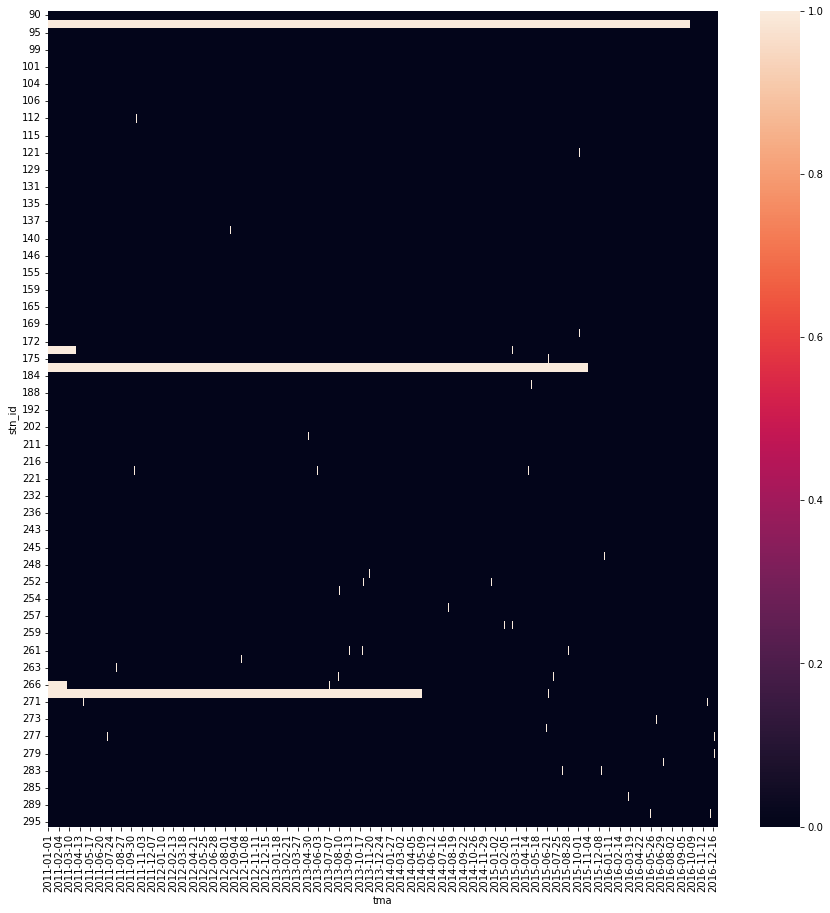

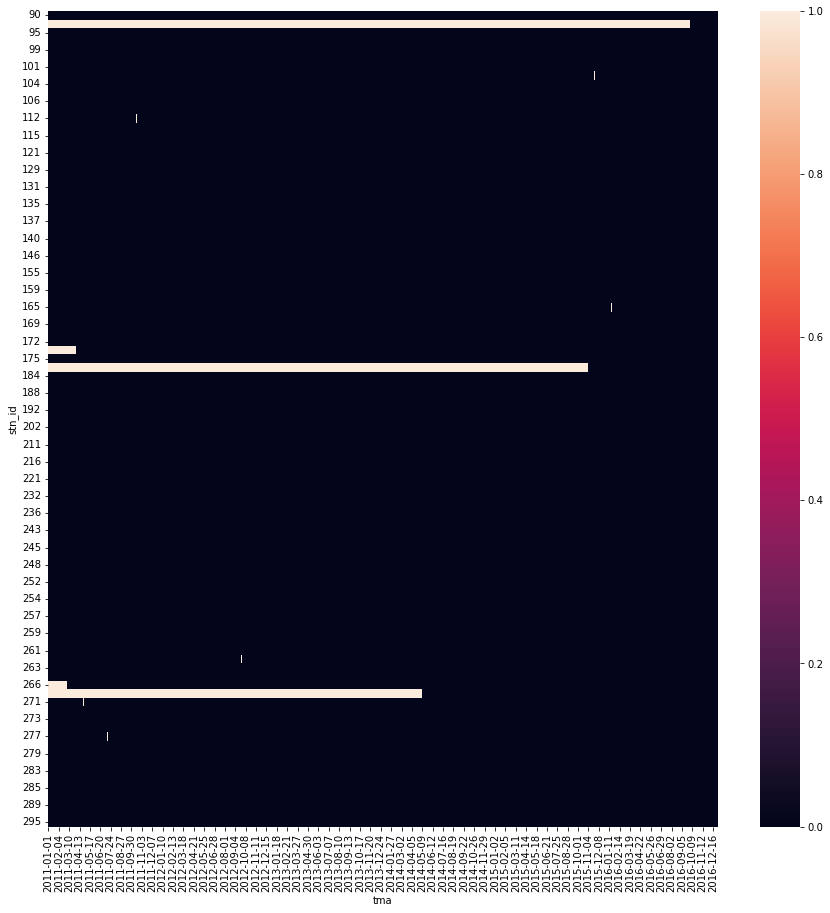

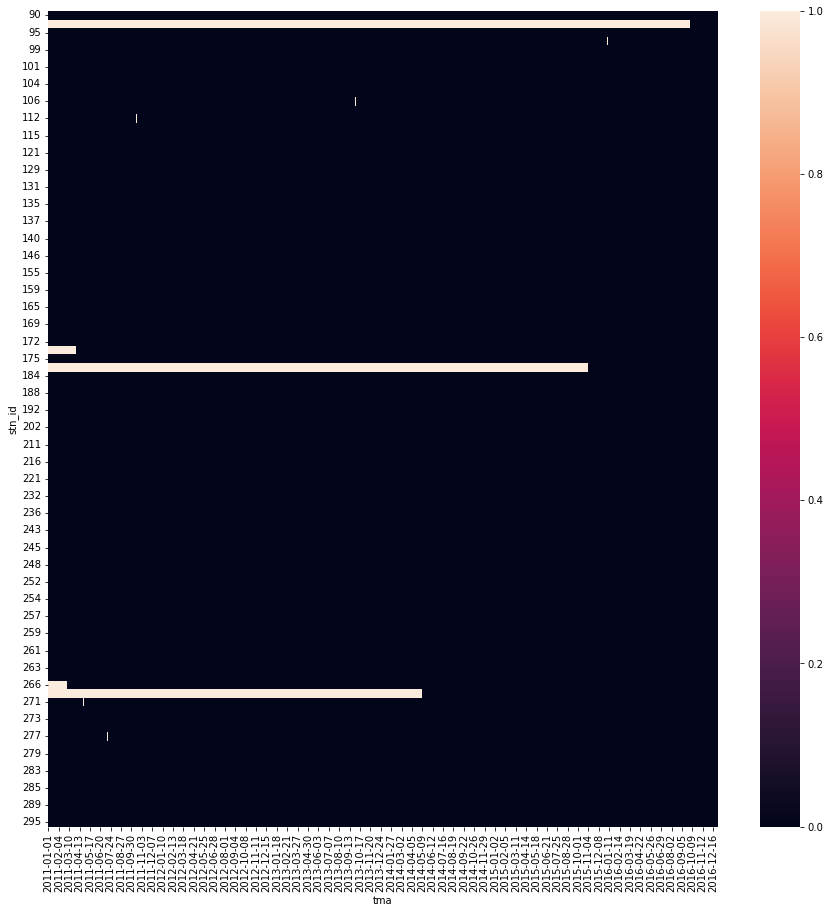

In [2]:
df = pd.read_csv("null_sfc_ta.csv", encoding = "utf-8-sig")
for col in ["avg_ta", "max_ta", "min_ta"]:
    plt.figure(figsize = (15, 15))
    sns.heatmap(df.pivot_table(index = "stn_id", columns = "tma", values = col, aggfunc = lambda x: x.isnull().mean()))
    plt.show()


In [3]:
plt.figure(figsize = (15, 15))
drop_idx = pd.DataFrame(df.pivot_table(index = "stn_id", columns = "tma", values = "avg_ta", aggfunc = lambda x: x.isnull().mean()).mean(axis = 1), columns = ["null"]).query("null > 0.5").index
df.query("stn_id in @drop_idx")[["stn_id", "add"]].drop_duplicates()

,stn_id,add
201664,268,전남
203856,177,충남
206048,93,강원


<Figure size 1080x1080 with 0 Axes>

In [4]:
df[["stn_id", "add"]].drop_duplicates()["add"].value_counts()

강원    14
전남    14
경남    14
경북    14
전북    10
충남     6
경기     5
충북     5
제주     4
인천     3
서울     1
울산     1
대구     1
부산     1
대전     1
광주     1
Name: add, dtype: int64

In [17]:
df = df.query("stn_id not in @drop_idx").reset_index(drop = True)

In [22]:
df.to_csv("null_sfc_ta_0802.csv", encoding = "utf-8-sig", index = False)

In [14]:
df = pd.read_csv("null_sfc_ta_0802.csv", encoding = "utf-8-sig")

In [6]:
df.pivot_table(index = "stn_id", columns = "tma", values = "avg_ta", aggfunc = lambda x: x.isnull().mean()).reset_index(drop = True).mean()

tma
2011-01-01    0.021739
2011-01-02    0.021739
2011-01-03    0.021739
2011-01-04    0.021739
2011-01-05    0.021739
                ...   
2016-12-27    0.000000
2016-12-28    0.000000
2016-12-29    0.010870
2016-12-30    0.000000
2016-12-31    0.000000
Length: 2192, dtype: float64

In [7]:
null_time = pd.DataFrame(df.pivot_table(index = "stn_id", columns = "tma", values = "avg_ta", aggfunc = lambda x: x.isnull().mean()).reset_index(drop = True).mean(), columns = ["time"])
atm = null_time.query("time == 1").index
atm = df.query("tma in @atm").index #모든 관측소 동시에 결측된 경우
stm = null_time.query("time > 0.5 and time < 1").index
stm = df[df["avg_ta"].isnull()].query("tma in @stm").index #대부분의 관측소가 결측된 경우
ntm = null_time.query("time > 0 and time < 0.5").index
ntm = df[df["avg_ta"].isnull()].query("tma in @ntm").index #몇몇 관측소만 결측된 경우

In [8]:
display(df.loc[atm, :])
display(df.loc[stm, :])
display(df.loc[ntm, :])

,yyyymmdd,tma,stn_id,avg_ta,max_ta,min_ta,name,address,lat,long,add


,yyyymmdd,tma,stn_id,avg_ta,max_ta,min_ta,name,address,lat,long,add


,yyyymmdd,tma,stn_id,avg_ta,max_ta,min_ta,name,address,lat,long,add
1704,20150901,2015-09-01,95,NaN,23.3,19.9,철원,강원도 철원군 갈말읍 군탄리,38.147885,127.304200,강원
7751,20140321,2014-03-21,106,NaN,7.4,0.3,동해,강원도 동해시 용정동,37.507095,129.124315,강원
19725,20161229,2016-12-29,172,NaN,2.3,-2.6,고창,전라북도 고창군 대산면 매산리,35.348220,126.599000,전북
21365,20150626,2015-06-26,175,NaN,21.0,15.6,진도(첨찰산),전라남도 진도군 의신면 운림산방로 527-209,34.472100,126.323800,전남
23502,20150502,2015-05-02,185,NaN,22.0,15.0,고산,제주특별자치도 제주시 한경면 고산리,33.293810,126.162815,제주
...,...,...,...,...,...,...,...,...,...,...,...
199559,20110329,2011-03-29,174,NaN,NaN,NaN,순천,전라남도 순천시 승주읍 평중리,35.020400,127.369400,전남
199560,20110330,2011-03-30,174,NaN,NaN,NaN,순천,전라남도 순천시 승주읍 평중리,35.020400,127.369400,전남
199561,20110331,2011-03-31,174,NaN,NaN,NaN,순천,전라남도 순천시 승주읍 평중리,35.020400,127.369400,전남
200112,20121002,2012-10-02,174,NaN,24.2,11.1,순천,전라남도 순천시 승주읍 평중리,35.020400,127.369400,전남


## 몇몇 관측소에서만 결측

In [161]:
def latlon(area, s):
    latlon = area.query("stn_id == @s")[["lat", "long"]].values[0]
    x = (np.cos(latlon[0]) * 6400 * 2 * np.pi / 360) * np.abs(latlon[1] - area[["long"]])
    y = 111 * np.abs(latlon[0] - area["lat"])
    area["distance"] = np.sqrt((x**2).squeeze() + y**2)
    return area

In [16]:
area3 = df[["stn_id", "address", "lat", "long", "add"]].drop_duplicates().reset_index(drop = True)
print(df.isnull().sum())
for col in ["avg_ta", "max_ta", "min_ta"]:
    s_idx = df[df[col].isnull()]["stn_id"].unique()
    for s in s_idx:
        area3 = latlon(area3, s)
        #print(area3.query("distance < 50"))
        df1 = pd.merge(df, area3[["stn_id", "distance"]], on = "stn_id", how = "left")
        df1["index"] = df1.index
        df1 = df1.set_index("distance")
        ymd = df[df[col].isnull()].query("stn_id == @s")["tma"].unique()
        for y in ymd:
            #print(s, y)
            idx = df.query("stn_id == @s and tma == @y").index
            #display(df1.query("tma == @y").interpolate(method = "index").query("distance < 100"))
            df.loc[idx, col] = df1.query("tma == @y").interpolate(method = "index").query("stn_id == @s")[col].values[0]
    print(df.isnull().sum())

yyyymmdd      0
tma           0
stn_id        0
avg_ta      268
max_ta      169
min_ta      168
name          0
address       0
lat           0
long          0
add           0
dtype: int64
yyyymmdd      0
tma           0
stn_id        0
avg_ta        1
max_ta      169
min_ta      168
name          0
address       0
lat           0
long          0
add           0
dtype: int64
yyyymmdd      0
tma           0
stn_id        0
avg_ta        1
max_ta        0
min_ta      168
name          0
address       0
lat           0
long          0
add           0
dtype: int64
yyyymmdd    0
tma         0
stn_id      0
avg_ta      1
max_ta      0
min_ta      0
name        0
address     0
lat         0
long        0
add         0
dtype: int64


In [27]:
df[df["avg_ta"].isnull()] #해당 결측치는 time index기준으로 메꿔줌

,yyyymmdd,tma,stn_id,avg_ta,max_ta,min_ta,name,address,lat,long,add
1704,20150901,2015-09-01,95,NaN,23.3,19.9,철원,강원도 철원군 갈말읍 군탄리,38.147885,127.3042,강원


In [41]:
idx = df[df["avg_ta"].isnull()].index
df.loc[idx, "avg_ta"] = df[df["stn_id"] == df.loc[idx, "stn_id"].values[0]].interpolate().loc[idx, "avg_ta"].values[0]
df.isnull().sum()

yyyymmdd    0
tma         0
stn_id      0
avg_ta      0
max_ta      0
min_ta      0
name        0
address     0
lat         0
long        0
add         0
dtype: int64

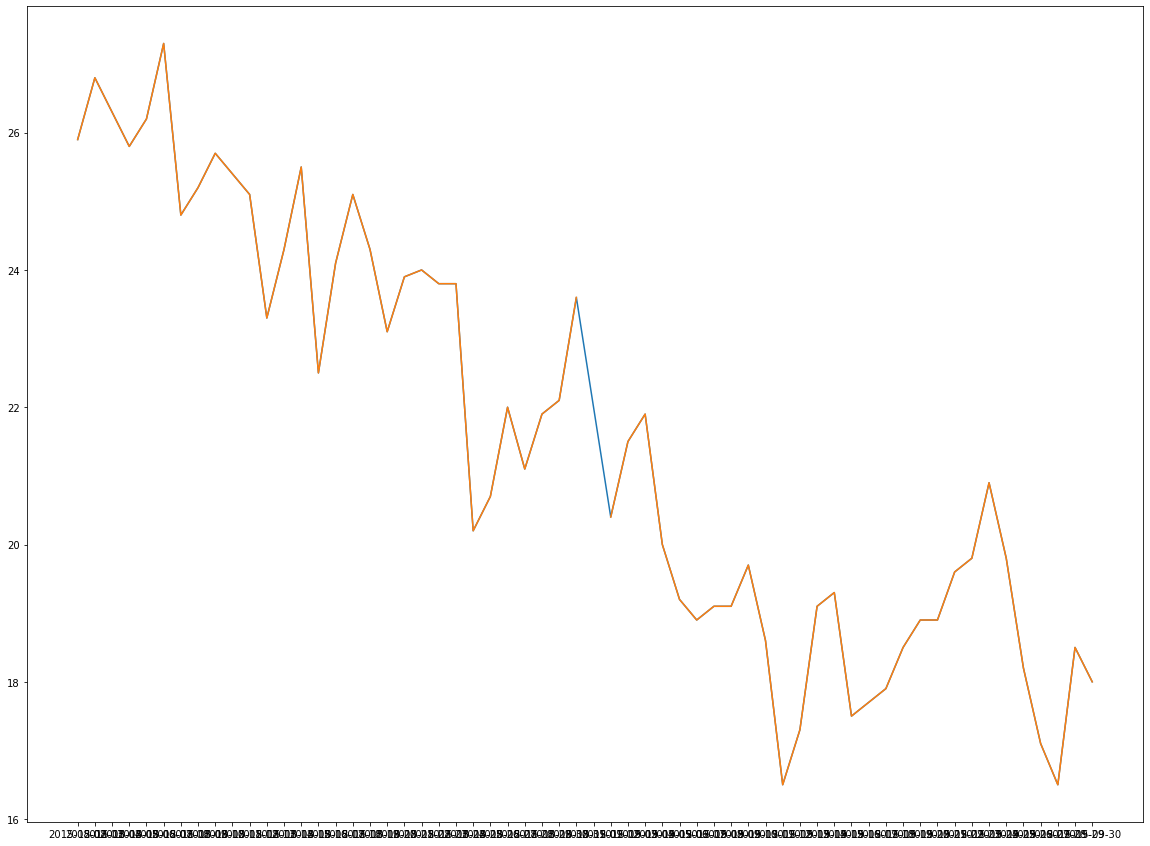

In [42]:
plt.figure(figsize = (20, 15))
df1 = pd.read_csv("null_sfc_ta_0802.csv", encoding = "utf-8-sig")
plt.plot(df[df["stn_id"] == 95].query("yyyymmdd > 20150801 and yyyymmdd < 20151001")["tma"], df[df["stn_id"] == 95].interpolate().query("yyyymmdd > 20150801 and yyyymmdd < 20151001")["avg_ta"])
plt.plot(df1[df1["stn_id"] == 95].query("yyyymmdd > 20150801 and yyyymmdd < 20151001")["tma"], df1[df1["stn_id"] == 95].query("yyyymmdd > 20150801 and yyyymmdd < 20151001")["avg_ta"])
plt.show()

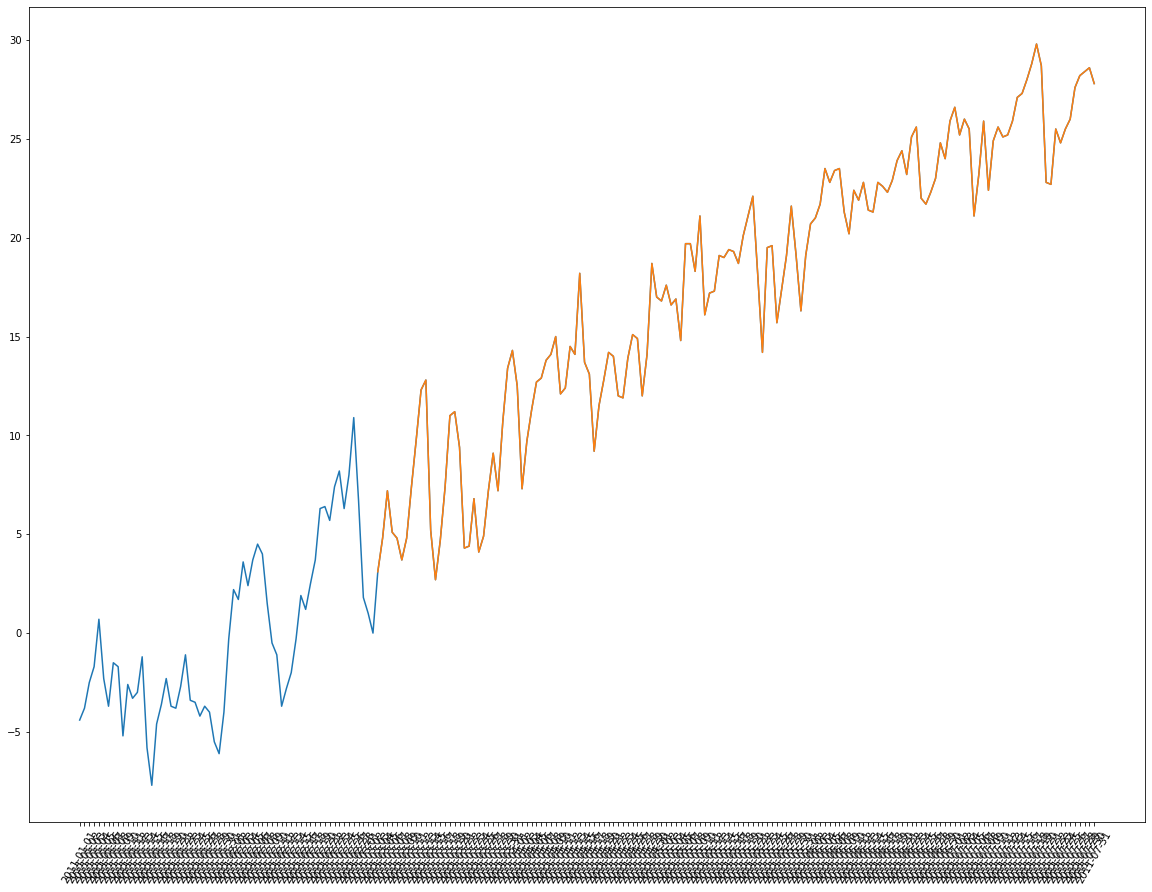

In [43]:
plt.figure(figsize = (20, 15)) #나머지 관측소들
plt.plot(df[df["stn_id"] == 266].query("yyyymmdd < 20110801")["tma"].values, df[df["stn_id"] == 266].query("yyyymmdd < 20110801")["avg_ta"].values)
plt.plot(df1[df1["stn_id"] == 266].query("yyyymmdd < 20110801")["tma"].values, df1[df1["stn_id"] == 266].query("yyyymmdd < 20110801")["avg_ta"].values)
plt.xticks(rotation = 60)
plt.show()

In [44]:
df.to_csv("final_sfc_ta_0803_lin.csv", encoding = "utf-8-sig", index = False)

# 참조시계열 인덱스 기준
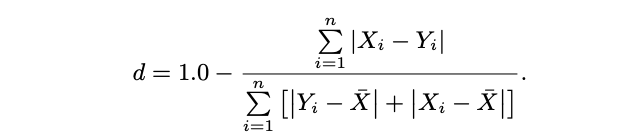

## Adjusted Normal Ratio Method
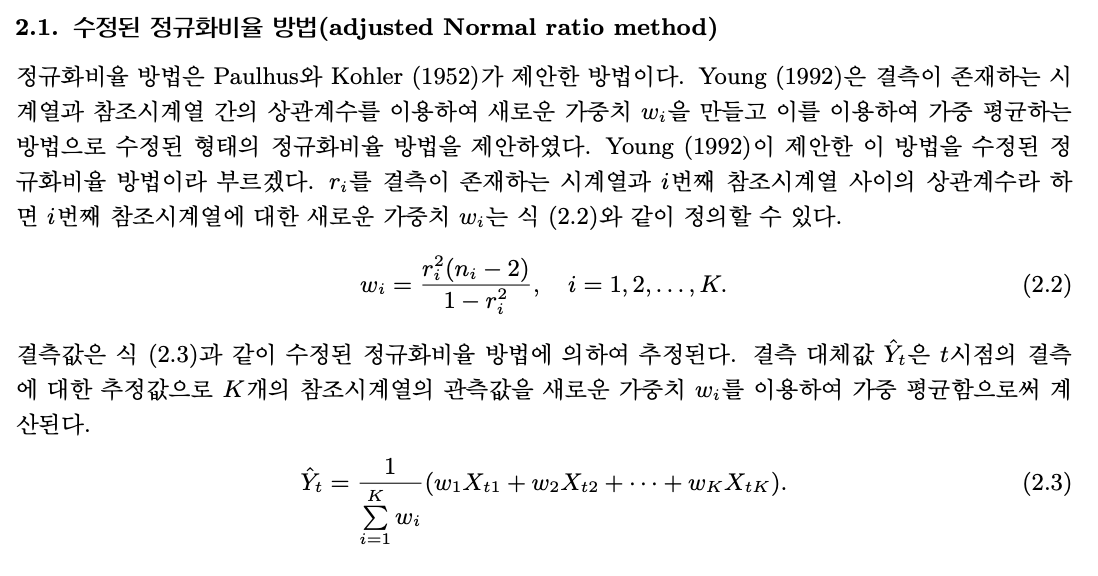

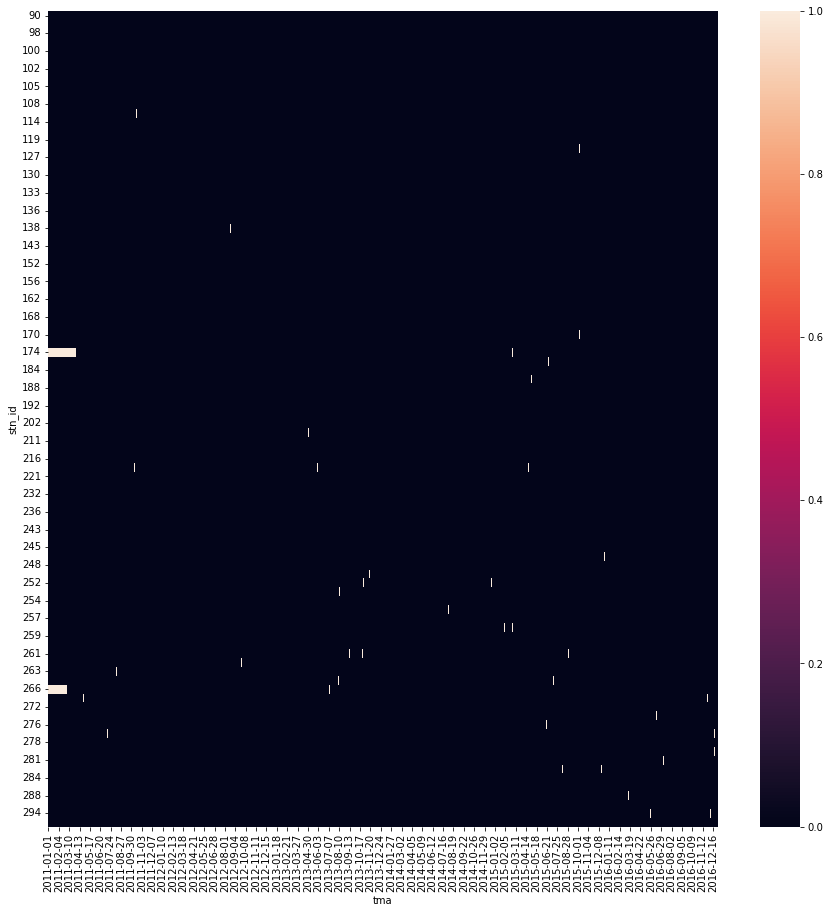

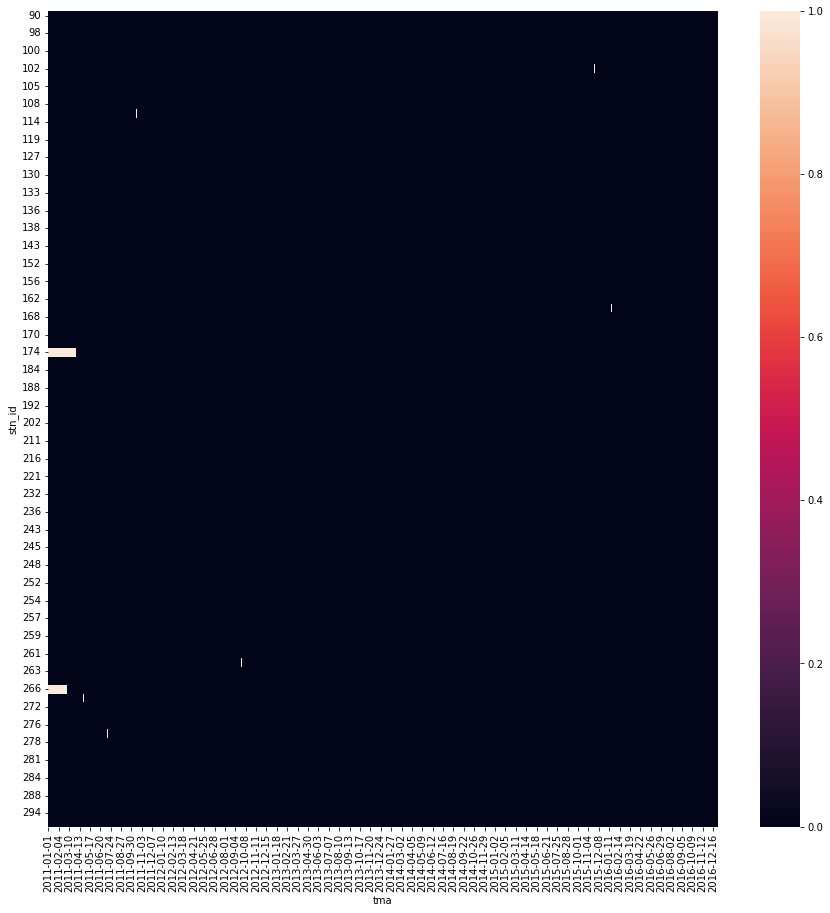

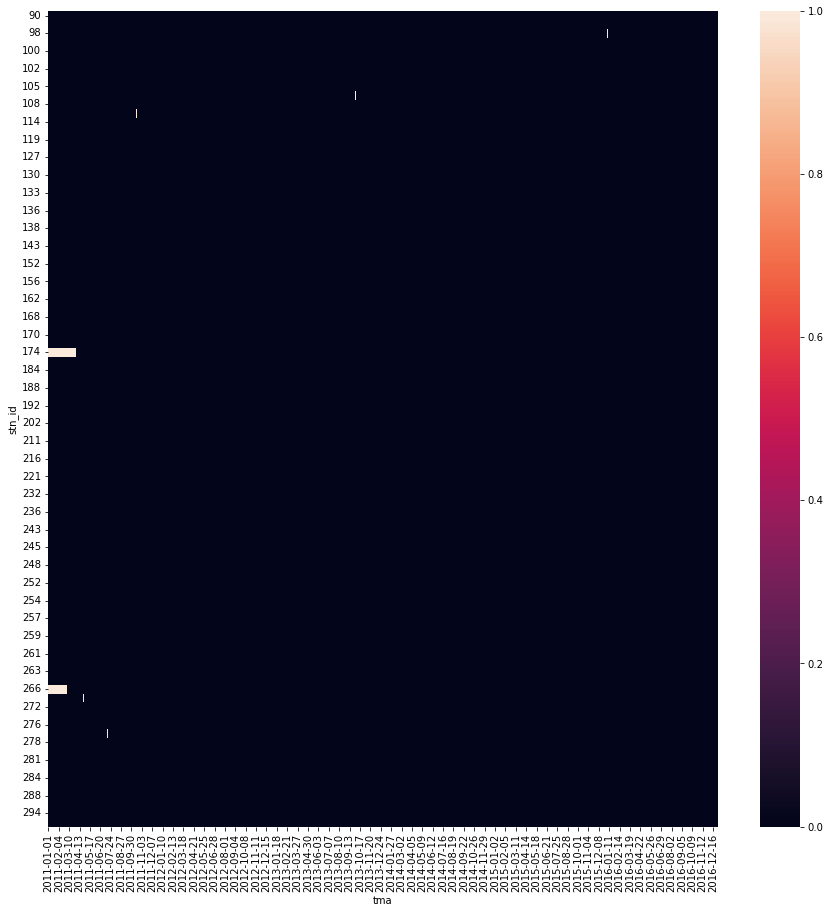

In [45]:
df = pd.read_csv("null_sfc_ta_0802.csv", encoding = "utf-8-sig")
for col in ["avg_ta", "max_ta", "min_ta"]:
    plt.figure(figsize = (15, 15))
    sns.heatmap(df.pivot_table(index = "stn_id", columns = "tma", values = col, aggfunc = lambda x: x.isnull().mean()))
    plt.show()

In [46]:
def dateidx(df, col):
    index = pd.DataFrame()
    for s in df[df[col].isnull()]["stn_id"].unique():
        #print(s, df[df["stn_id"] == s]["address"].unique())
        ymd = df[df[col].isnull()].query("stn_id == @s")["yyyymmdd"].unique()
        if len(ymd) == 1:
            #print(ymd)
            idx = pd.DataFrame([[s, ymd[0], ymd[0]]], columns = ["stn_id", "start", "end"])
            index = pd.concat([index, idx], axis = 0).reset_index(drop = True)
        else:
            for i in range(len(ymd)):
                if i == 0:
                    idx = [s]
                    #print("Start : ", ymd[i])
                    idx.append(ymd[i])
                    continue
                elif ymd[i] - ymd[i - 1] > 1:
                    #print("End : ", ymd[i - 1])
                    idx.append(ymd[i-1])
                    idx = pd.DataFrame([idx], columns = ["stn_id", "start", "end"])
                    index = pd.concat([index, idx], axis = 0).reset_index(drop = True)
                    idx = [s]
                    #print("Start : ", ymd[i])
                    idx.append(ymd[i])
                elif i == len(ymd) - 1:
                    #print("End : ", ymd[i])
                    idx.append(ymd[i])
                    idx = pd.DataFrame([idx], columns = ["stn_id", "start", "end"])
                    index = pd.concat([index, idx], axis = 0).reset_index(drop = True)
        #print("\n")
    index["start"] = index["start"].apply(lambda x: str(x)[:4] + "-" + str(x)[4:6] + "-" + str(x)[6:])
    index["end"] = index["end"].apply(lambda x: str(x)[:4] + "-" + str(x)[4:6] + "-" + str(x)[6:])
    return index
dateidx(df, "avg_ta")

,stn_id,start,end
0,95,2015-09-01,2015-09-01
1,106,2014-03-21,2014-03-21
2,172,2016-12-29,2016-12-29
3,175,2015-06-26,2015-06-26
4,185,2015-05-02,2015-05-02
...,...,...,...
78,266,2013-07-08,2013-07-10
79,174,2011-01-01,2011-01-31
80,174,2011-02-01,2011-02-28
81,174,2011-03-01,2011-03-31


In [120]:
def timeperiod(index, df, col, i, delta = 30):
    st = int(str(date.fromisoformat(index.loc[i, "start"]) - timedelta(days = delta)).replace("-", ""))
    ed = int(str(index.loc[i, "start"]).replace("-", ""))
    idx = df.query("yyyymmdd >= @st and yyyymmdd < @ed").reset_index(drop = True)
    st = int(str(index.loc[i, "end"]).replace("-", ""))
    ed = int(str(date.fromisoformat(index.loc[i, "end"]) + timedelta(days = delta)).replace("-", ""))
    idx = pd.concat([idx, df.query("yyyymmdd > @st and yyyymmdd <= @ed").reset_index(drop = True)], axis = 0).reset_index(drop = True)
    idx = idx.pivot(index = "yyyymmdd", columns = "stn_id", values = col)
    return idx

In [166]:
def d_index(idx):
    d_idx = []
    for j in idx.columns:
        xi = idx.loc[:, j]
        xbar = np.nanmean(xi)
        num = np.sum(np.abs(xi - tg))
        den = np.sum(np.abs(tg - xbar) + np.abs(xi - xbar))
        #print("num : ", num, " / den : ", den)
        d_idx.append([j, 1 - num / den])
    stn_idx = pd.DataFrame(d_idx, columns = ["stn_id", "d_index"]).sort_values("d_index", ascending = False).head(n)["stn_id"].values
    ni = idx.loc[:, stn_idx].notnull().sum().values - 2
    ri2 = pd.concat([pd.DataFrame(tg), idx.loc[:, stn_idx]], axis = 1).corr().iloc[0, 1:].values
    print(ri2)
    ri2 = np.where(ri2 == 1, 0.999, ri2)
    wi = (ni * ri2) / (1 - ri2)
    print(wi)
    wi = wi / np.sum(wi)
    print(wi)
    return stn_idx, wi

In [168]:
def lin_distance(df, columns):
    area3 = df[["stn_id", "lat", "long", "add"]].drop_duplicates().reset_index(drop = True)
    for col in columns:
        print(col)
        index = dateidx(df, col) #원래대로라면 함수로 만들긴 해야 하는데,,,
        print(df.isnull().sum())
        for i in range(index.shape[0]):
            #print(index.loc[i, "stn_id"])
            s = index.loc[i, "stn_id"]
            # distance
            area3 = latlon(area3, s)
            # less than 70km
            df1 = pd.merge(df, area3[["stn_id", "distance"]], on = "stn_id", how = "left").query("distance <= 70")
            # +- 30 Days from NaN
            idx = timeperiod(index, df1, col, i)
            #display(idx)
            tg = idx.loc[:, s]
            if idx.shape[1] == 1: #70km 이내 관측소가 자기 자신밖에 없을 경우 : 결측치 대체 불가능. PASS
                print("CHECK AGAIN stn_id : ", s)
                continue
            idx = idx.drop(s, axis = 1)
            stn_idx, wi = d_index(idx)
            st = int(str(index.loc[i, "start"]).replace("-", ""))
            ed = int(str(index.loc[i, "end"]).replace("-", ""))
            tg_idx = df1[df1["stn_id"] == s].query("yyyymmdd >= @st and yyyymmdd <= @ed").index
            ymd = df1.loc[tg_idx, "yyyymmdd"].values
            d_idx = df1.query("stn_id in @stn_idx and yyyymmdd in @ymd").pivot(index = "yyyymmdd", columns = "stn_id", values = col)
            #print(d_idx)
            out = pd.DataFrame()
            for k in range(len(stn_idx)):
                out = pd.concat([out, pd.DataFrame(d_idx.loc[:, stn_idx[k]].values * wi[k])], axis = 1)
                #print(out)
            #display("OUT", out)
            #print(np.nanmean(out, axis = 1))
            #print(np.mean(out[out.notnull()], axis = 1).values[0])
            out = np.nanmean(out, axis = 1)
            #print(df1.loc[tg_idx, col])
            #print(out)
            #print(len(out) == len(df1.loc[tg_idx, col]))
            #print("")
            df.loc[tg_idx, col] = out
            del df1
        print(df.isnull().sum())
    return df

In [169]:
from datetime import date, timedelta
df = pd.read_csv("null_sfc_ta_0802.csv", encoding = "utf-8-sig")
columns = ["avg_ta", "max_ta", "min_ta"]
lin_distance(df, columns)

avg_ta
yyyymmdd      0
tma           0
stn_id        0
avg_ta      268
max_ta      169
min_ta      168
name          0
address       0
lat           0
long          0
add           0
dtype: int64
[nan nan nan]
[nan nan nan]
[nan nan nan]
[nan nan nan nan nan]
[nan nan nan nan nan]
[nan nan nan nan nan]


/var/folders/5j/xbj_5dc97zz4h76plmswc5640000gn/T/ipykernel_88337/605741507.py:9: RuntimeWarning: invalid value encountered in double_scalars
  d_idx.append([j, 1 - num / den])
/var/folders/5j/xbj_5dc97zz4h76plmswc5640000gn/T/ipykernel_88337/443136429.py:36: RuntimeWarning: Mean of empty slice
  out = np.nanmean(out, axis = 1)


[nan nan nan nan nan]
[nan nan nan nan nan]
[nan nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan]
[nan nan nan]
[nan nan nan]
[nan nan nan nan nan]
[nan nan nan nan nan]
[nan nan nan nan nan]
[nan nan nan nan nan]
[nan nan nan nan nan]
[nan nan nan nan nan]
[nan nan nan nan nan]
[nan nan nan nan nan]
[nan nan nan nan nan]
[nan nan nan nan nan]
[nan nan nan nan nan]
[nan nan nan nan nan]
[nan nan nan nan nan]
[nan nan nan nan nan]
[nan nan nan nan nan]
[0.8504745  0.88656811 0.85749764 0.72213688 0.77355607]
[329.89371457 453.32006789 349.01079594 150.73587322 198.13404801]
[0.22273644 0.306071   0.23564384 0.1017733  0.13377543]
[nan nan nan nan nan]
[nan nan nan nan nan]
[nan nan nan nan nan]
[nan nan nan nan nan]
[nan nan nan nan nan]
[nan nan nan nan nan]
[nan nan nan nan nan]
[nan nan nan nan nan]
[nan nan nan nan nan]
[nan nan nan nan nan]
[nan nan nan nan nan]
[nan nan nan nan nan]
[nan nan nan nan nan]
[nan nan nan nan nan]
[nan nan nan nan na

/var/folders/5j/xbj_5dc97zz4h76plmswc5640000gn/T/ipykernel_88337/605741507.py:5: RuntimeWarning: Mean of empty slice
  xbar = np.nanmean(xi)


[nan nan nan nan nan]
[nan nan nan nan nan]
[nan nan nan nan nan]
[nan nan nan nan nan]
[nan nan nan nan nan]
[nan nan nan nan nan]
[nan nan nan nan nan]
[nan nan nan nan nan]
[nan nan nan nan nan]
[nan nan nan nan nan]
[nan nan nan nan nan]
[nan nan nan nan nan]
[nan nan nan nan nan]
[nan nan nan nan nan]
[nan nan nan nan nan]
[nan nan nan nan nan]
[nan nan nan nan nan]
[nan nan nan nan nan]
[nan nan nan nan nan]
[nan nan nan nan nan]
[nan nan nan nan nan]
[0.92852425 0.9428273  0.96314815 0.93053965 0.95858601]
[ 753.46402772  956.47016958 1515.86924602  777.00879451 1342.49293528]
[0.14095809 0.17893649 0.28358891 0.14536285 0.25115366]
yyyymmdd      0
tma           0
stn_id        0
avg_ta      265
max_ta      169
min_ta      168
name          0
address       0
lat           0
long          0
add           0
dtype: int64
max_ta
yyyymmdd      0
tma           0
stn_id        0
avg_ta      265
max_ta      169
min_ta      168
name          0
address       0
lat           0
long        

,yyyymmdd,tma,stn_id,avg_ta,max_ta,min_ta,name,address,lat,long,add
0,20110101,2011-01-01,95,-11.3,-0.7,-18.5,철원,강원도 철원군 갈말읍 군탄리,38.147885,127.3042,강원
1,20110102,2011-01-02,95,-11.1,0.0,-18.4,철원,강원도 철원군 갈말읍 군탄리,38.147885,127.3042,강원
2,20110103,2011-01-03,95,-9.2,3.6,-17.7,철원,강원도 철원군 갈말읍 군탄리,38.147885,127.3042,강원
3,20110104,2011-01-04,95,-9.2,-1.0,-17.5,철원,강원도 철원군 갈말읍 군탄리,38.147885,127.3042,강원
4,20110105,2011-01-05,95,-6.0,-1.9,-13.4,철원,강원도 철원군 갈말읍 군탄리,38.147885,127.3042,강원
...,...,...,...,...,...,...,...,...,...,...,...
201659,20161227,2016-12-27,174,1.1,4.0,-3.2,순천,전라남도 순천시 승주읍 평중리,35.020400,127.3694,전남
201660,20161228,2016-12-28,174,-0.5,7.0,-6.3,순천,전라남도 순천시 승주읍 평중리,35.020400,127.3694,전남
201661,20161229,2016-12-29,174,-1.2,2.3,-3.8,순천,전라남도 순천시 승주읍 평중리,35.020400,127.3694,전남
201662,20161230,2016-12-30,174,-0.5,5.2,-5.2,순천,전라남도 순천시 승주읍 평중리,35.020400,127.3694,전남


In [170]:
lin_distance(df, columns)

avg_ta
yyyymmdd      0
tma           0
stn_id        0
avg_ta      265
max_ta      167
min_ta      166
name          0
address       0
lat           0
long          0
add           0
dtype: int64
[nan nan nan]
[nan nan nan]
[nan nan nan]


/var/folders/5j/xbj_5dc97zz4h76plmswc5640000gn/T/ipykernel_88337/605741507.py:9: RuntimeWarning: invalid value encountered in double_scalars
  d_idx.append([j, 1 - num / den])
/var/folders/5j/xbj_5dc97zz4h76plmswc5640000gn/T/ipykernel_88337/443136429.py:36: RuntimeWarning: Mean of empty slice
  out = np.nanmean(out, axis = 1)


[nan nan nan nan nan]
[nan nan nan nan nan]
[nan nan nan nan nan]
[nan nan nan nan nan]
[nan nan nan nan nan]
[nan nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan]
[nan nan nan]
[nan nan nan]
[nan nan nan nan nan]
[nan nan nan nan nan]
[nan nan nan nan nan]
[nan nan nan nan nan]
[nan nan nan nan nan]
[nan nan nan nan nan]
[nan nan nan nan nan]
[nan nan nan nan nan]
[nan nan nan nan nan]
[nan nan nan nan nan]
[nan nan nan nan nan]
[nan nan nan nan nan]
[nan nan nan nan nan]
[nan nan nan nan nan]
[nan nan nan nan nan]
[nan nan nan nan nan]
[nan nan nan nan nan]
[nan nan nan nan nan]
[nan nan nan nan nan]
[nan nan nan nan nan]
[nan nan nan nan nan]
[nan nan nan nan nan]
[nan nan nan nan nan]
[nan nan nan nan nan]
[nan nan nan nan nan]
[nan nan nan nan nan]
[nan nan nan nan nan]
[nan nan nan nan nan]
[nan nan nan nan nan]
[nan nan nan nan nan]
[nan nan nan nan nan]
[nan nan nan nan nan]
[nan nan nan nan nan]
[nan nan nan nan nan]
[nan nan nan nan nan]
[n

/var/folders/5j/xbj_5dc97zz4h76plmswc5640000gn/T/ipykernel_88337/605741507.py:5: RuntimeWarning: Mean of empty slice
  xbar = np.nanmean(xi)


[nan nan nan nan nan]
[nan nan nan nan nan]
[nan nan nan nan nan]
[nan nan nan nan nan]
[nan nan nan nan nan]
[nan nan nan nan nan]
[nan nan nan nan nan]
[nan nan nan nan nan]
[nan nan nan nan nan]
[nan nan nan nan nan]
[nan nan nan nan nan]
[nan nan nan nan nan]
[nan nan nan nan nan]
[nan nan nan nan nan]
[nan nan nan nan nan]
[nan nan nan nan nan]
[nan nan nan nan nan]
[nan nan nan nan nan]
[nan nan nan nan nan]
[nan nan nan nan nan]
[nan nan nan nan nan]
yyyymmdd      0
tma           0
stn_id        0
avg_ta      264
max_ta      167
min_ta      166
name          0
address       0
lat           0
long          0
add           0
dtype: int64
max_ta
yyyymmdd      0
tma           0
stn_id        0
avg_ta      264
max_ta      167
min_ta      166
name          0
address       0
lat           0
long          0
add           0
dtype: int64
CHECK AGAIN stn_id :  102
[nan nan nan nan nan]
[nan nan nan nan nan]
[nan nan nan nan nan]
[nan nan nan nan nan]
[nan nan nan nan nan]
[nan nan nan nan 

,yyyymmdd,tma,stn_id,avg_ta,max_ta,min_ta,name,address,lat,long,add
0,20110101,2011-01-01,95,-11.3,-0.7,-18.5,철원,강원도 철원군 갈말읍 군탄리,38.147885,127.3042,강원
1,20110102,2011-01-02,95,-11.1,0.0,-18.4,철원,강원도 철원군 갈말읍 군탄리,38.147885,127.3042,강원
2,20110103,2011-01-03,95,-9.2,3.6,-17.7,철원,강원도 철원군 갈말읍 군탄리,38.147885,127.3042,강원
3,20110104,2011-01-04,95,-9.2,-1.0,-17.5,철원,강원도 철원군 갈말읍 군탄리,38.147885,127.3042,강원
4,20110105,2011-01-05,95,-6.0,-1.9,-13.4,철원,강원도 철원군 갈말읍 군탄리,38.147885,127.3042,강원
...,...,...,...,...,...,...,...,...,...,...,...
201659,20161227,2016-12-27,174,1.1,4.0,-3.2,순천,전라남도 순천시 승주읍 평중리,35.020400,127.3694,전남
201660,20161228,2016-12-28,174,-0.5,7.0,-6.3,순천,전라남도 순천시 승주읍 평중리,35.020400,127.3694,전남
201661,20161229,2016-12-29,174,-1.2,2.3,-3.8,순천,전라남도 순천시 승주읍 평중리,35.020400,127.3694,전남
201662,20161230,2016-12-30,174,-0.5,5.2,-5.2,순천,전라남도 순천시 승주읍 평중리,35.020400,127.3694,전남


In [138]:
lin_distance(df, columns)

avg_ta
yyyymmdd     0
tma          0
stn_id       0
avg_ta      32
max_ta      32
min_ta      31
name         0
address      0
lat          0
long         0
add          0
dtype: int64
yyyymmdd     0
tma          0
stn_id       0
avg_ta       0
max_ta      32
min_ta      31
name         0
address      0
lat          0
long         0
add          0
dtype: int64
max_ta
yyyymmdd     0
tma          0
stn_id       0
avg_ta       0
max_ta      32
min_ta      31
name         0
address      0
lat          0
long         0
add          0
dtype: int64
CHECK AGAIN stn_id :  102
yyyymmdd     0
tma          0
stn_id       0
avg_ta       0
max_ta       1
min_ta      31
name         0
address      0
lat          0
long         0
add          0
dtype: int64
min_ta
yyyymmdd     0
tma          0
stn_id       0
avg_ta       0
max_ta       1
min_ta      31
name         0
address      0
lat          0
long         0
add          0
dtype: int64
yyyymmdd    0
tma         0
stn_id      0
avg_ta      0
max_ta 

,yyyymmdd,tma,stn_id,avg_ta,max_ta,min_ta,name,address,lat,long,add
0,20110101,2011-01-01,95,-11.3,-0.7,-18.5,철원,강원도 철원군 갈말읍 군탄리,38.147885,127.3042,강원
1,20110102,2011-01-02,95,-11.1,0.0,-18.4,철원,강원도 철원군 갈말읍 군탄리,38.147885,127.3042,강원
2,20110103,2011-01-03,95,-9.2,3.6,-17.7,철원,강원도 철원군 갈말읍 군탄리,38.147885,127.3042,강원
3,20110104,2011-01-04,95,-9.2,-1.0,-17.5,철원,강원도 철원군 갈말읍 군탄리,38.147885,127.3042,강원
4,20110105,2011-01-05,95,-6.0,-1.9,-13.4,철원,강원도 철원군 갈말읍 군탄리,38.147885,127.3042,강원
...,...,...,...,...,...,...,...,...,...,...,...
201659,20161227,2016-12-27,174,1.1,4.0,-3.2,순천,전라남도 순천시 승주읍 평중리,35.020400,127.3694,전남
201660,20161228,2016-12-28,174,-0.5,7.0,-6.3,순천,전라남도 순천시 승주읍 평중리,35.020400,127.3694,전남
201661,20161229,2016-12-29,174,-1.2,2.3,-3.8,순천,전라남도 순천시 승주읍 평중리,35.020400,127.3694,전남
201662,20161230,2016-12-30,174,-0.5,5.2,-5.2,순천,전라남도 순천시 승주읍 평중리,35.020400,127.3694,전남


In [141]:
df[df["max_ta"].isnull()]

,yyyymmdd,tma,stn_id,avg_ta,max_ta,min_ta,name,address,lat,long,add
6172,20151124,2015-11-24,102,2.5,NaN,1.0,백령도,인천광역시 옹진군 백령면 연화리,37.97003,124.671435,인천


In [171]:
df = df.interpolate()
df.isnull().sum()

yyyymmdd    0
tma         0
stn_id      0
avg_ta      0
max_ta      0
min_ta      0
name        0
address     0
lat         0
long        0
add         0
dtype: int64

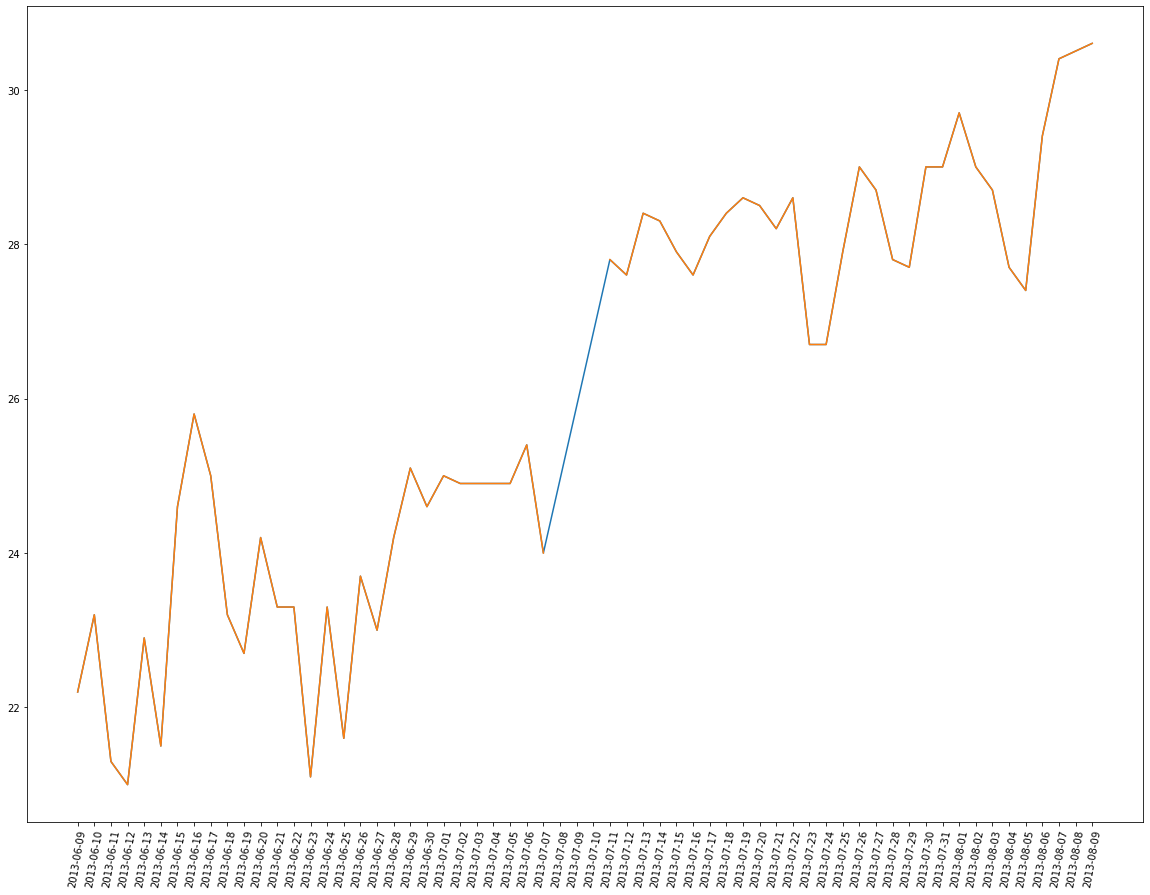

In [172]:
plt.figure(figsize = (20, 15))
df1 = pd.read_csv("null_sfc_ta_0802.csv", encoding = "utf-8-sig")
plt.plot(df[df["stn_id"] == 266].query("yyyymmdd > 20130608 and yyyymmdd < 20130810")["tma"], df[df["stn_id"] == 266].query("yyyymmdd > 20130608 and yyyymmdd < 20130810")["avg_ta"])
plt.plot(df[df["stn_id"] == 266].query("yyyymmdd > 20130608 and yyyymmdd < 20130810")["tma"], df1[df1["stn_id"] == 266].query("yyyymmdd > 20130608 and yyyymmdd < 20130810")["avg_ta"])
plt.xticks(rotation = 80)
plt.show()

In [175]:
index = dateidx(df1, "avg_ta")
print(index["stn_id"].value_counts().head())

217    6
283    5
263    5
174    4
266    4
Name: stn_id, dtype: int64


In [176]:
index[index["stn_id"] == 217]

,stn_id,start,end
44,217,2011-07-24,2011-07-25
45,217,2011-08-17,2011-08-18
46,217,2011-10-09,2011-10-10
47,217,2013-05-31,2013-05-31
48,217,2014-05-28,2014-05-28
49,217,2015-04-22,2015-04-22


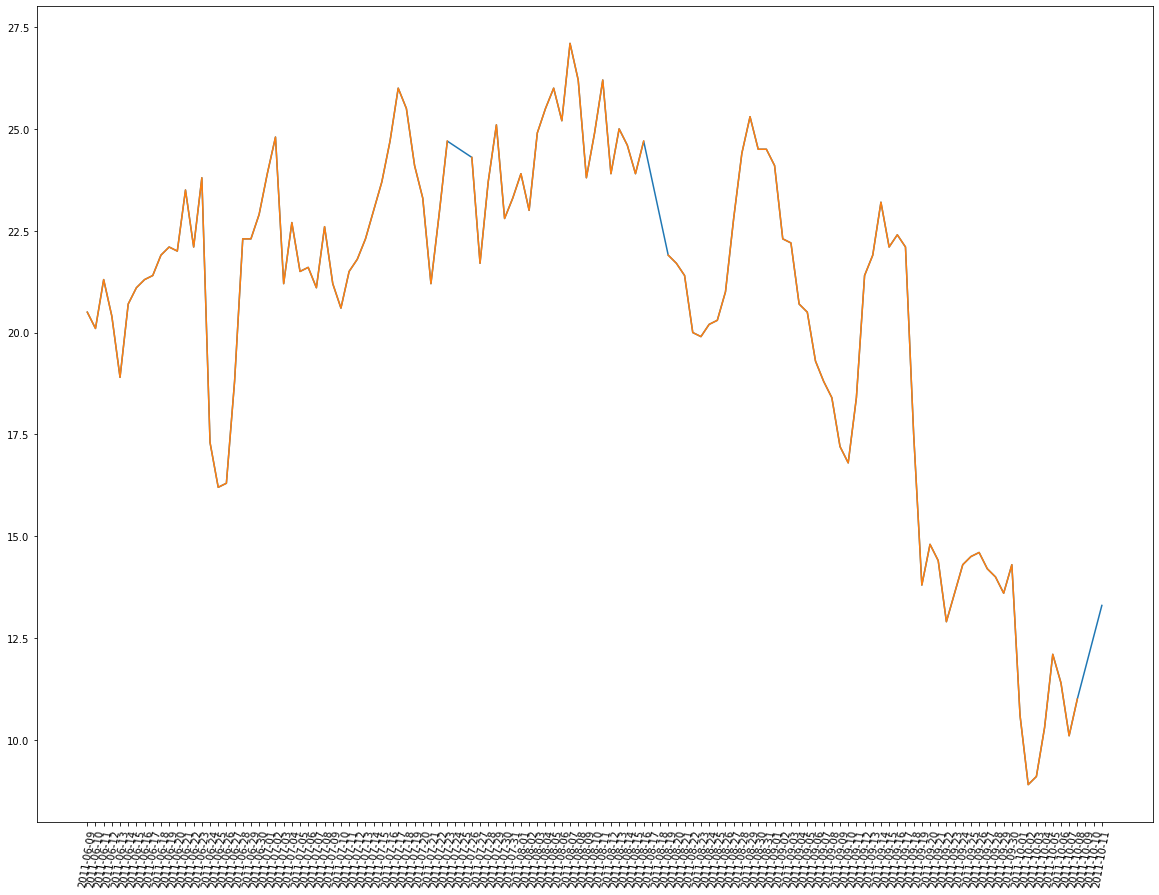

In [177]:
plt.figure(figsize = (20, 15))
plt.plot(df[df["stn_id"] == 217].query("yyyymmdd > 20110608 and yyyymmdd < 20111012")["tma"], df[df["stn_id"] == 217].query("yyyymmdd > 20110608 and yyyymmdd < 20111012")["avg_ta"])
plt.plot(df[df["stn_id"] == 217].query("yyyymmdd > 20110608 and yyyymmdd < 20111012")["tma"], df1[df1["stn_id"] == 217].query("yyyymmdd > 20110608 and yyyymmdd < 20111012")["avg_ta"])
plt.xticks(rotation = 80)
plt.show()

In [178]:
df.to_csv("final_sfc_ta_0807_norm.csv", encoding = "utf-8-sig", index = False)